# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
#from ddpg_agent import Agent
from maddpg_agent_v3 import MADDPG
import matplotlib.pyplot as plt
from collections import deque
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


import sys, importlib, inspect, hashlib
import maddpg_agent_v3

# 1) WHICH FILE is actually being imported?
print("MADDPG module path:", maddpg_agent_v3.__file__)

# 2) DID the 'learn' body change? (fingerprint it)
src = inspect.getsource(maddpg_agent_v3.MADDPG.learn).encode()
print("learn() md5:", hashlib.md5(src).hexdigest())

# 3) WHAT hyperparams are in the module *right now*?
# print("TAU:", maddpg_agent_v2.TAU)
# print("GAMMA:", maddpg_agent_v2.GAMMA)
# print("OU SIGMA DECAY:", maddpg_agent_v2.OU_SIGMA_DECAY)

# 4) OPTIONAL: show the exact a_all_next logic line
print(inspect.getsource(maddpg_agent_v3.MADDPG.learn).splitlines()[0:80])  # glance at smoothing code

MADDPG module path: c:\Users\succi\repos\drl-tennis\maddpg_agent_v3.py
learn() md5: f1fd12456a415b5d3be366b0edaf21bc
['    def learn(self, experiences, gamma):', '        # each agent uses its own actor to calculate next_actions', '        all_next_actions = []', '        all_actions = []', '        for i, agent in enumerate(self.agents):', '            states, _, _, next_states, _ = experiences[i]', '            agent_id = torch.tensor([i]).to(device)', "            # extract agent i's state and get action via actor network", '            state = states.reshape(-1, 2, 24).index_select(1, agent_id).squeeze(1)', '            action = agent.actor_local(state)', '            all_actions.append(action)', "            # extract agent i's next state and get action via target actor network", '            next_state = next_states.reshape(-1, 2, 24).index_select(1, agent_id).squeeze(1)', '            next_action = agent.actor_target(next_state)', '            all_next_actions.append(next_action

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

#agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=0,num_agents=1)
#agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=0,num_agents=1)

#maddpg = MADDPG(noise_start=0.5, state_size=state_size, action_size=action_size, num_agents=2, random_seed=2)
maddpg = MADDPG(seed=2, noise_start=0.5, update_every=2, gamma=0.99, t_stop_noise=30000)

def plot_scores(scores, window=100, solved_score=30.0, savepath=None):
    """
    Plot per-episode scores and a moving average.
    Args:
        scores (list[float]): one score per episode
        window (int): moving-average window (Udacity uses 100)
        solved_score (float): horizontal reference line (30 for Reacher)
        savepath (str|None): if set, saves the figure to this path
    """
    scores = np.asarray(scores, dtype=float)
    episodes = np.arange(1, len(scores) + 1)

    # moving average (uses cumulative average if fewer than window points)
    if len(scores) >= window:
        ma = np.convolve(scores, np.ones(window)/window, mode='valid')
        ma_x = np.arange(window, len(scores) + 1)
    else:
        ma = np.cumsum(scores) / episodes
        ma_x = episodes

    fig, ax = plt.subplots()
    ax.plot(episodes, scores, label="Score per episode")
    ax.plot(ma_x, ma, label=(f"Moving avg ({window})" if len(scores) >= window else "Cumulative avg"))
    ax.set_xlabel("Episode")
    ax.set_ylabel("Score")
    ax.set_title("Training performance")
    ax.legend(loc="best")
    if solved_score is not None:
        ax.axhline(solved_score, linestyle="--", linewidth=1)
    if savepath:
        fig.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.show()

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

c:\Users\succi\anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.008
Episode 200	Average Score: 0.007
Episode 300	Average Score: 0.004
Episode 400	Average Score: 0.003
Episode 500	Average Score: 0.001
Episode 600	Average Score: 0.016
Episode 700	Average Score: 0.010
Episode 800	Average Score: 0.042
Episode 900	Average Score: 0.048
Episode 1000	Average Score: 0.043
Episode 1100	Average Score: 0.029
Episode 1200	Average Score: 0.059
Episode 1300	Average Score: 0.071
Episode 1400	Average Score: 0.091
Episode 1500	Average Score: 0.080
Episode 1600	Average Score: 0.089
Episode 1700	Average Score: 0.076
Episode 1800	Average Score: 0.083
Episode 1900	Average Score: 0.094
Episode 2000	Average Score: 0.089
Episode 2100	Average Score: 0.086
Episode 2200	Average Score: 0.095
Episode 2300	Average Score: 0.090
Episode 2400	Average Score: 0.094
Episode 2500	Average Score: 0.060
Episode 2600	Average Score: 0.065
Episode 2700	Average Score: 0.094
Episode 2800	Average Score: 0.096
Episode 2900	Average Score: 0.100
Episode 3000	Average Sc

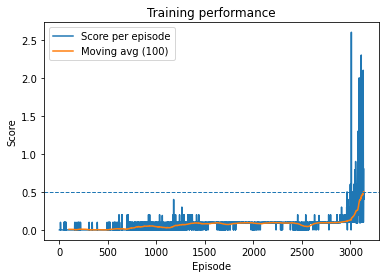

In [5]:
def ddpg(n_episodes=5000, print_every=100):
    scores_deque = deque(maxlen=100)     # 100-episode window
    scores = []                          # episode scores (one scalar per episode)
    scores_avg = []

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                      # shape: (2, state_size)
        scorestab = np.zeros(num_agents)  
        rewardslist = []


        while True:
            actions = maddpg.act(states, i_episode)                # (2, action_size), float32 in [-1,1]
            #print(f"\rEpisode: {i_episode}\tactions: {actions}")
            env_info   = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards     = env_info.rewards               # [r1, r2]
            dones       = env_info.local_done            # [d1, d2]
            scorestab += env_info.rewards 

            maddpg.step(states, actions, rewards, next_states, dones)

            states = next_states
            rewardslist.append(rewards)

            if np.any(dones):
                break

        # Udacity Tennis uses the max of the two agents per episode
        episode_reward = np.max(np.sum(np.array(rewardslist),axis=0))
        #ep_score = max(ep_ret_1, ep_ret_2)     
        scores_deque.append(episode_reward)
        #scores.append(ep_score)
        scores.append(episode_reward)   
        current_avg_score = np.mean(scores_deque)
        scores_avg.append(current_avg_score) 

        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score),end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score))
       
        # break and report success if environment is solved
        if np.mean(scores_deque)>=.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            #agent.save_agents()
            break

        # Solve when moving average over last 100 episodes >= 0.5
        if len(scores_deque) == 100 and current_avg_score >= 0.5:
            print(f"\n\nEnvironment solved in {i_episode} episodes!\tAvg(100): {current_avg_score:.4f}")

            torch.save(maddpg.actors_local[0].state_dict(), 'actor1.pth')
            torch.save(maddpg.actors_local[1].state_dict(), 'actor2.pth')
            torch.save(maddpg.critics_local[0].state_dict(), 'critic1.pth')
            torch.save(maddpg.critics_local[1].state_dict(), 'critic2.pth')

            break

    return scores



scores = ddpg()

plot_scores(scores, window=100, solved_score=.5, savepath="tennis_scores.png")

When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```